In [533]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fname = "data2017_Skim.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

In [534]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

E_collections = emevents.Electron
M_collections = emevents.Muon

#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)

Opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents = emevents[Opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj

M_collections = M_collections[M_collections.Target==1]
trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

trg_Match = ak.flatten(M_collections[:,0].delta_r(trg_collections) < 0.5)

emevents = emevents[trg_Match]
emu = emevents.Muon[:,0] + emevents.Electron[:,0]

In [542]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("mass", "e_mu mass", 50, 110, 160),
        )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        Opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[Opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.flatten(M_collections[:,0].delta_r(trg_collections) < 0.5)

        return emevents[trg_Match]
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emuevents = self.Vetos(events)
        emu = emevents.Muon[:,0] + emevents.Electron[:,0]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=emu.mass,
            #weight=numpy.ones(len(emu.mass))
        )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [543]:
import glob
import os
from time import process_time
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
fsetGG = glob.glob('/hdfs/store/user/kaho/NanoPost1/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/NanoTestPost1_GluGlu_LFV_HToEMu_M125/*/*/*root')
fsetSigMu = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')


samples = {
    #"GGToEMu": fset,
    "Single Mu": [fname]
}

t1_start = process_time() 
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = process_time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

Elapsed time: 3.4816335500000832


<AxesSubplot:xlabel='e_mu mass', ylabel='Events'>

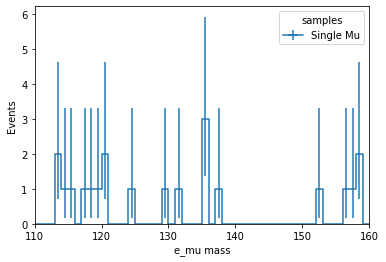

In [548]:
%matplotlib inline

hist.plot1d(result)

In [549]:
import uproot3
fout = uproot3.recreate('output.root')
a = result['Single Mu'].to_boost()
b = (a.to_numpy()[0][0], a.to_numpy()[-1])
fout['Single Mu'] = b
#fout['Single Mu'].show()
fout.close()

In [556]:
fout = uproot3.open('output.root')
#fout['Single Mu'].show()
fout.close()